In [5]:
import numpy as np
import pandas as pd
from scipy.special import softmax

In [6]:
!pip install datasets

In [7]:
from datasets import load_dataset

ds = load_dataset("cardiffnlp/tweet_eval", "offensive")

In [8]:
tweeteval = pd.concat([ds['train'].to_pandas(), ds['test'].to_pandas(),ds['validation'].to_pandas()])
tweeteval.head()

,text,label
0,@user Bono... who cares. Soon people will unde...,0
1,@user Eight years the republicans denied obama...,1
2,@user Get him some line help. He is gonna be j...,0
3,@user @user She is great. Hi Fiona!,0
4,@user She has become a parody unto herself? Sh...,1


In [14]:
# prompt: calclulate acc and f1 and also plot a good looking confusion matrix. true label: tweeteval['label'], pred_label: tweeteval['pred']
def eval_function(df,true_column,pred_column):
  from sklearn.metrics import accuracy_score, f1_score
  import matplotlib.pyplot as plt
  import seaborn as sns
  from sklearn.metrics import confusion_matrix

  # Calculate accuracy and F1-score
  accuracy = accuracy_score(df[true_column], df[pred_column])
  f1 = f1_score(df[true_column], df[pred_column])

  print(f"Accuracy: {accuracy}")
  print(f"F1-score: {f1}")

  # Create confusion matrix
  cm = confusion_matrix(df[true_column], df[pred_column])

  # Plot confusion matrix
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
              xticklabels=['Not Offensive', 'Offensive'],
              yticklabels=['Not Offensive', 'Offensive'])
  plt.xlabel('Predicted Label')
  plt.ylabel('True Label')
  plt.title('Confusion Matrix')
  plt.show()


In [1]:
!pip install huggingface_hub


In [3]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) Y
Token is valid (permission: write).
The token `hatebert` has been saved to /root/.cache/huggingface/stored_tokens
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when 

In [9]:
len(tweeteval)

14100

### DistilRoberta

In [6]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("distilroberta-base")
model = AutoModelForSequenceClassification.from_pretrained("silvglad/distilroberta-olid-lr5e5-wd001")

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/329M [00:00<?, ?B/s]

In [25]:
import torch
from scipy.special import softmax

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device).eval()

# Example inference function
def classify_tweet(tweet, max_length=128):
    encoded = tokenizer(tweet, truncation=True, padding='max_length',
                        max_length=max_length, return_tensors='pt').to(device)
    with torch.no_grad():
        logits = model(**encoded).logits
        probs = softmax(logits.cpu().numpy(), axis=1)[0]
        pred_label = probs.argmax()

    labels = {0: 'Not Offensive', 1: 'Offensive',2 : '2',3 : '3', 4: '4'}
    return labels[pred_label], probs.round(3)

# Example usage:
tweet ="all muslims go to hell"
# tweet = "you are such a black man who cant be seen in dark"
# tweet = "You muslims are such idiots!"
label, confidence = classify_tweet(tweet)

print(f"Tweet: '{tweet}'")
print(f"Prediction: {label}, Confidence: {confidence}")

# 4 - indiv
# 3 - grp

Tweet: 'all muslims go to hell'
Prediction: 3, Confidence: [0.094 0.04  0.112 0.602 0.153]


'\n4 - indiv\n3 - grp\n\n'

In [19]:
# Check the actual labels for this model
id2label = model.config.id2label
print(id2label)

{0: 'LABEL_0', 1: 'LABEL_1', 2: 'LABEL_2', 3: 'LABEL_3', 4: 'LABEL_4'}


In [28]:
from scipy.special import softmax
from tqdm import tqdm

def predict_offensive(tweets, batch_size=32):
    predictions, scores = [], []
    for i in tqdm(range(0, len(tweets), batch_size)):
        batch = tweets[i:i+batch_size].tolist()
        encoded = tokenizer(batch, padding=True, truncation=True, return_tensors="pt").to(device)

        with torch.no_grad():
            outputs = model(**encoded)
            probs = softmax(outputs.logits.cpu().numpy(), axis=1)
            preds = probs.argmax(axis=1)
            predictions.extend(preds)
            scores.extend(probs[:, 1])  # Offensive probability
    return predictions, scores

# Apply prediction on your olid DataFrame
tweeteval['pred'], tweeteval['offensive_prob'] = predict_offensive(tweeteval['text'])

# Map predictions to labels
labels = {0: 'Not Offensive', 1: 'Offensive',2: 'Offensive',3: 'Offensive',4:'Offensive'}
tweeteval['pred_label'] = tweeteval['pred'].map(labels)

# Check results
tweeteval.head()

100%|██████████| 441/441 [00:32<00:00, 13.38it/s]


,text,label,pred,offensive_prob,pred_label
0,@user Bono... who cares. Soon people will unde...,0,0,0.011013,Not Offensive
1,@user Eight years the republicans denied obama...,1,4,0.034412,4
2,@user Get him some line help. He is gonna be j...,0,0,0.009055,Not Offensive
3,@user @user She is great. Hi Fiona!,0,0,0.003222,Not Offensive
4,@user She has become a parody unto herself? Sh...,1,4,0.018752,4


Accuracy: 0.8550354609929078
F1-score: 0.7677272727272727


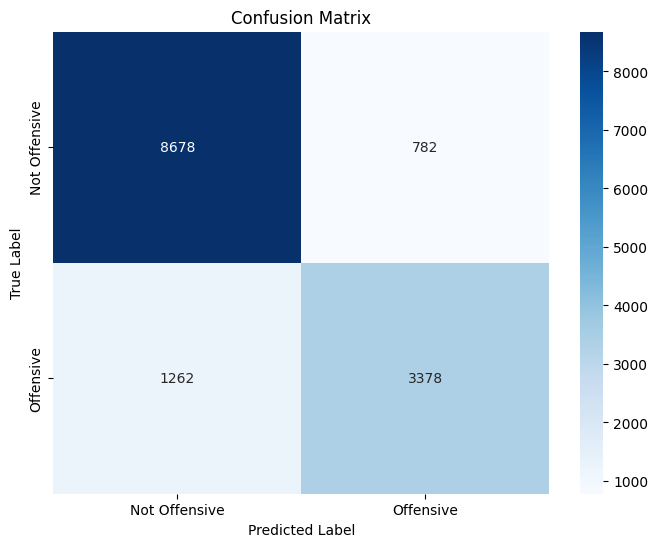

In [41]:
# prompt: calclulate acc and f1 and also plot a good looking confusion matrix. true label: tweeteval['label'], pred_label: tweeteval['pred']

from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate accuracy and F1-score
accuracy = accuracy_score(tweeteval['label'], tweeteval['pred'])
f1 = f1_score(tweeteval['label'], tweeteval['pred'])

print(f"Accuracy: {accuracy}")
print(f"F1-score: {f1}")

# Create confusion matrix
cm = confusion_matrix(tweeteval['label'], tweeteval['pred'])

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Offensive', 'Offensive'],
            yticklabels=['Not Offensive', 'Offensive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [42]:
tweeteval.to_csv('tweeteval_distilroberta.csv',index=False)

### KoalaAI

In [2]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

model = AutoModelForSequenceClassification.from_pretrained("KoalaAI/OffensiveSpeechDetector", use_auth_token=True)

tokenizer = AutoTokenizer.from_pretrained("KoalaAI/OffensiveSpeechDetector", use_auth_token=True)

inputs = tokenizer("I love AutoTrain", return_tensors="pt")

outputs = model(**inputs)

/usr/local/lib/python3.11/dist-packages/transformers/models/auto/auto_factory.py:471: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/974 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/557M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/auto/tokenization_auto.py:823: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/963 [00:00<?, ?B/s]

In [11]:
import torch
import torch.nn.functional as F
from tqdm import tqdm

def classify_tweets_batch(texts, model, tokenizer, device):
    """
    Classifies a list of tweets in a single batch.

    Args:
        texts (list): List of tweet strings.
        model: Pre-trained sequence classification model.
        tokenizer: Corresponding tokenizer.
        device (str): Device to run inference on.

    Returns:
        List of predicted labels.
    """
    # Tokenize a batch of texts with padding and truncation
    inputs = tokenizer(texts, return_tensors="pt", truncation=True, padding=True)
    # Move inputs to the specified device
    inputs = {key: value.to(device) for key, value in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    probs = F.softmax(logits, dim=-1)
    # Get predictions as a list (moved to CPU)
    predicted_idxs = torch.argmax(probs, dim=-1).cpu().tolist()

    # Convert indices to labels if possible
    labels = []
    for idx in predicted_idxs:
        if hasattr(model.config, "id2label"):
            labels.append(model.config.id2label[idx])
        else:
            labels.append(str(idx))

    # Clean up CUDA memory
    del inputs, outputs, logits, probs
    torch.cuda.empty_cache()

    return labels

def classify_dataset(df, text_column="text", batch_size=32, model=None, tokenizer=None, device="cuda"):
    """
    Classifies tweets in the DataFrame using batch processing.

    Args:
        df (pandas.DataFrame): DataFrame containing tweet texts.
        text_column (str): Name of the column containing tweets.
        batch_size (int): Number of tweets to process per batch.
        model: Pre-trained sequence classification model.
        tokenizer: Corresponding tokenizer.
        device (str): Device to run inference on.

    Returns:
        DataFrame with a new 'prediction' column.
    """
    predictions = []
    texts = df[text_column].tolist()

    # Process tweets in batches with a progress bar
    for i in tqdm(range(0, len(texts), batch_size), desc="Classifying batches"):
        batch = texts[i:i + batch_size]
        batch_preds = classify_tweets_batch(batch, model, tokenizer, device)
        predictions.extend(batch_preds)

    df["prediction"] = predictions
    return df


# Move model to CUDA
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# Classify the dataset (adjust text_column if needed)
tweeteval = classify_dataset(tweeteval, text_column="text", batch_size=32, model=model, tokenizer=tokenizer, device=device)
tweeteval.head()

Classifying batches: 100%|██████████| 441/441 [01:30<00:00,  4.87it/s]


,text,label,prediction
0,@user Bono... who cares. Soon people will unde...,0,offensive
1,@user Eight years the republicans denied obama...,1,offensive
2,@user Get him some line help. He is gonna be j...,0,non-offensive
3,@user @user She is great. Hi Fiona!,0,non-offensive
4,@user She has become a parody unto herself? Sh...,1,offensive


In [15]:
tweeteval['pred_label'] = tweeteval['prediction'].map({"offensive":1,"non-offensive":0})

Accuracy: 0.7879432624113475
F1-score: 0.6633641071830669


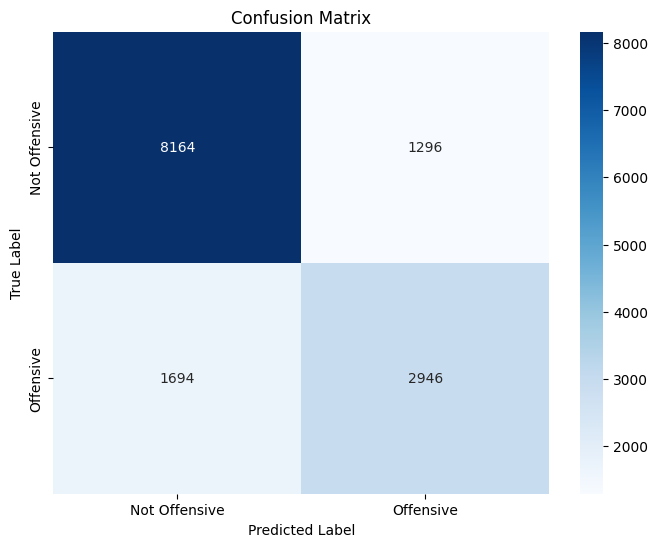

In [16]:
eval_function(tweeteval,"label","pred_label")

In [17]:
tweeteval.to_csv("tweeteval_koalaai.csv",index=False)

### Deberta-small-long

In [23]:
# prompt: empty cpu cache and gpu cache

import torch

# Empty CPU cache
torch.cuda.empty_cache()

# Empty GPU cache (if available)
if torch.cuda.is_available():
    torch.cuda.empty_cache()


In [25]:
import pandas as pd
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm import tqdm

def load_deberta_model():
    """
    Loads the DeBERTa model and tokenizer.

    Returns:
        model: The loaded model on the appropriate device.
        tokenizer: The corresponding tokenizer.
        device: 'cuda' if available, else 'cpu'.
    """
    tokenizer = AutoTokenizer.from_pretrained("tasksource/deberta-small-long-nli")
    model = AutoModelForSequenceClassification.from_pretrained("tasksource/deberta-small-long-nli")
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    return model, tokenizer, device

def classify_batch(texts, model, tokenizer, device, max_length=128):
    """
    Classifies a batch of texts.

    Args:
        texts (list): List of tweet strings.
        model: Pre-trained sequence classification model.
        tokenizer: Corresponding tokenizer.
        device (str): Device on which to run inference.
        max_length (int): Maximum token length.

    Returns:
        List of predicted label indices.
    """
    inputs = tokenizer(texts, return_tensors="pt", truncation=True, padding=True, max_length=max_length)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    # Use softmax then argmax to get predicted class index for each tweet
    preds = torch.argmax(F.softmax(logits, dim=-1), dim=-1).cpu().tolist()
    return preds

def classify_dataset(df, text_column="tweet", batch_size=32):
    """
    Classifies the texts in a pandas DataFrame using the DeBERTa model.

    Args:
        df (pd.DataFrame): DataFrame with tweet texts.
        text_column (str): Column name containing tweet text.
        batch_size (int): Number of samples per batch.

    Returns:
        DataFrame with a new 'prediction' column.
    """
    model, tokenizer, device = load_deberta_model()
    predictions = []
    texts = df[text_column].tolist()

    for i in tqdm(range(0, len(texts), batch_size), desc="Classifying batches"):
        batch_texts = texts[i:i+batch_size]
        batch_preds = classify_batch(batch_texts, model, tokenizer, device)
        predictions.extend(batch_preds)

    df["prediction"] = predictions
    return df

# Example usage:
if __name__ == "__main__":
    classified_df = classify_dataset(tweeteval, text_column="text", batch_size=32)
    classified_df.head()


Classifying batches: 100%|██████████| 441/441 [00:43<00:00, 10.19it/s]


In [26]:
classified_df.head()

,text,label,prediction,pred_label
0,@user Bono... who cares. Soon people will unde...,0,1,1
1,@user Eight years the republicans denied obama...,1,1,1
2,@user Get him some line help. He is gonna be j...,0,1,0
3,@user @user She is great. Hi Fiona!,0,1,0
4,@user She has become a parody unto herself? Sh...,1,2,1
